This is a siplified version of my food image classifier, where I only used a convolutional neural network.

# 0. Download the food images

In [2]:
!git clone https://github.com/Albert-Aiqi-Zhang/Food-Image-Classifier datasets

Cloning into 'datasets'...
remote: Enumerating objects: 1857, done.
remote: Total 1857 (delta 0), reused 0 (delta 0), pack-reused 1857
Receiving objects: 100% (1857/1857), 269.24 MiB | 14.29 MiB/s, done.
Resolving deltas: 100% (40/40), done.


# 1. Preprocessing

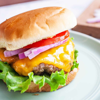

In [3]:
from PIL import Image
from numpy import asarray
import numpy as np
import torch
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import PIL
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

rng = np.random.RandomState(1234)
random_state = 42

dataset_root_dir = "/content/datasets/food_datasets"
dataset = datasets.ImageFolder(root=dataset_root_dir)

image = Image.open("datasets/food_datasets/1/1.png")
image

In [4]:
### Correct labels for all food images
labelNums = [96, 99, 98, 95, 96, 100, 98, 97, 97, 99]
y_labels = []
for i, labelNum in enumerate(labelNums):
  for j in range(labelNum):
    y_labels.append(i)

# merge data and labels
data_with_labels = []
for idx in range(len(dataset)):
  foodImage = dataset[idx][0]
  # numpy_image = np.asarray(foodImage)[:95:3, :95:3, :].transpose(2, 1, 0)
  numpy_image = np.asarray(foodImage).transpose(2, 1, 0)
  # data_with_labels.append([numpy_image.transpose(2, 1, 0), y_labels[i]])
  tensor_image = torch.from_numpy(numpy_image.astype(np.float32)).clone()
  data_with_labels.append([tensor_image, y_labels[idx]])

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


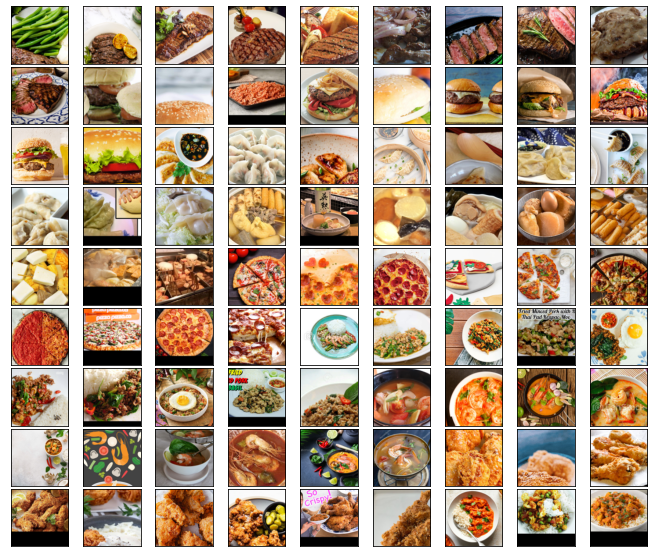

In [6]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

image_num = 81
for i in range(image_num):
  # ax = plt.subplot(image_num / 5, 5, i + 1)
  ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
  # plt.tight_layout()
  # ax.set_title(str(i))
  plt.imshow(dataset[i * 10][0])

# 2. Implementation of Convolutional Neural Network (CNN)

### 2.1. define layers of CNN

In [7]:
class BatchNorm(nn.Module):
    def __init__(self, shape, epsilon=np.float32(1e-5)):
        super().__init__()
        self.gamma = nn.Parameter(torch.tensor(np.ones(shape, dtype='float32')))
        self.beta = nn.Parameter(torch.tensor(np.zeros(shape, dtype='float32')))
        self.epsilon = epsilon

    def forward(self, x):
        mean = torch.mean(x, (0, 2, 3), keepdim=True)
        std = torch.std(x, (0, 2, 3), keepdim=True)
        x_normalized = (x - mean) / (std**2 + self.epsilon)**0.5
        return self.gamma * x_normalized + self.beta

class Conv(nn.Module):
    def __init__(self, filter_shape, function=lambda x: x, stride=(1, 1), padding=0):
        super().__init__()
        # Heの初期値
        fan_in = filter_shape[1] * filter_shape[2] * filter_shape[3]
        # filter_shape: (出力チャンネル数)x(入力チャンネル数)x(縦の次元数)x(横の次元数)
        fan_out = filter_shape[0] * filter_shape[2] * filter_shape[3]

        self.W = nn.Parameter(torch.tensor(rng.normal(
                        0,
                        np.sqrt(2/fan_in),
                        size=filter_shape
                    ).astype('float32')))

        # バイアスはフィルタごとなので, 出力フィルタ数と同じ次元数
        self.b = nn.Parameter(torch.tensor(np.zeros((filter_shape[0]), dtype='float32')))

        self.function = function
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        u = F.conv2d(x, self.W, bias=self.b, stride=self.stride, padding=self.padding)
        return self.function(u)

class Pooling(nn.Module):
    def __init__(self, ksize=(2, 2), stride=(2, 2), padding=0):
        super().__init__()
        self.ksize = ksize
        self.stride = stride
        self.padding = padding

    def forward(self, x):
        return F.avg_pool2d(x, kernel_size=self.ksize, stride=self.stride, padding=self.padding)

class Flatten(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.view(x.size()[0], -1)

class Dense(nn.Module):
    def __init__(self, in_dim, out_dim, function=lambda x: x):
        super().__init__()
        # He Initialization
        # in_dim: 入力の次元数、out_dim: 出力の次元数
               
        self.W = nn.Parameter(torch.tensor(rng.normal(
                        0,
                        np.sqrt(2/in_dim),
                        size=(in_dim, out_dim)
                    ).astype('float32')))

        self.b = nn.Parameter(torch.tensor(np.zeros([out_dim]).astype('float32')))
        self.function = function

    def forward(self, x):
        return self.function(torch.matmul(x, self.W) + self.b)

class Activation(nn.Module):
    def __init__(self, function=lambda x: x):
        super().__init__()
        self.function = function

    def __call__(self, x):
        return self.function(x)

def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-10))

In [78]:
conv_net = nn.Sequential(
    # Conv((32, 3, 3, 3)),     # 32x32x3 -> 30x30x32
    Conv((32, 3, 71, 71)),
    BatchNorm((32, 30, 30)),
    Activation(F.relu),
    Pooling((2, 2)),                  # 30x30x32 -> 15x15x32
    Conv((64, 32, 3, 3)),     # 15x15x32 -> 13x13x64
    BatchNorm((64, 13, 13)),
    Activation(F.relu),
    Pooling((2, 2)),                 # 13x13x64 -> 6x6x64
    Conv((128, 64, 3, 3)),           # 6x6x64 -> 4x4x128
    BatchNorm((128, 4, 4)),
    Activation(F.relu),
    Pooling((2, 2)),                 # 4x4x128 -> 2x2x128
    Flatten(),
    Dense(2*2*128, 256, F.relu),
    Dense(256, 10)
)

batch_size = 32
n_epochs = 50
lr = 0.01
device = 'cuda'

conv_net.to(device)
optimizer = optim.Adam(conv_net.parameters(), lr=lr)

In [86]:
# trainval_dataset = datasets.CIFAR10('./data/cifar10', train=True, transform=transforms.ToTensor())

# #zcaを定義
# zca = ZCAWhitening()
# zca.fit(trainval_dataset)

# # 前処理を定義
# transform = transforms.Compose([transforms.ToTensor(),
#                                 zca])

# trainval_dataset = datasets.CIFAR10('./data/cifar10', train=True, transform=transform)

# trainとvalidに分割
# training data: 65%
# validation data: 10%
# test data: 25%
total_length = len(data_with_labels)
length_trainAndValid = int(total_length * 0.75)
length_test = total_length - length_trainAndValid
length_train = int(total_length * 0.65)
length_valid = length_trainAndValid - length_train
trainAndValid_dataset, test_dataset = torch.utils.data.random_split(data_with_labels, [length_trainAndValid, length_test])
train_dataset, valid_dataset = torch.utils.data.random_split(trainAndValid_dataset, [length_train, length_valid])

batch_size = 32

dataloader_train = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=batch_size,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [70]:
for item in(dataloader_test):
  print(item[0].shape)

torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([32, 3, 32, 32])
torch.Size([20, 3, 32, 32])


### 2.2 training

In [87]:
training_accuracy = []
validation_accuracy = []

for epoch in range(n_epochs):
    losses_train = []
    losses_valid = []

    conv_net.train()
    n_train = 0
    acc_train = 0
    for x, t in dataloader_train:
        n_train += t.size()[0]

        conv_net.zero_grad()  # 勾配の初期化

        x = x.to(device)  # テンソルをGPUに移動

        t_hot = torch.eye(10)[t]  # 正解ラベルをone-hot vector化

        t = t.to(device)
        t_hot = t_hot.to(device)  # 正解ラベルとone-hot vectorをそれぞれGPUに移動

        y = conv_net.forward(x)  # 順伝播

        loss = -(t_hot*torch.log_softmax(y, dim=-1)).sum(axis=1).mean()  # 誤差(クロスエントロピー誤差関数)の計算

        loss.backward()  # 誤差の逆伝播

        optimizer.step()  # パラメータの更新

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_train += (pred == t).float().sum().item()
        losses_train.append(loss.tolist())

    conv_net.eval()
    n_val = 0
    acc_val = 0
    for x, t in dataloader_valid:
        n_val += t.size()[0]

        x = x.to(device)  # テンソルをGPUに移動

        t_hot = torch.eye(10)[t]  # 正解ラベルをone-hot vector化

        t = t.to(device)
        t_hot = t_hot.to(device)  # 正解ラベルとone-hot vectorをそれぞれGPUに移動

        y = conv_net.forward(x)  # 順伝播

        loss = -(t_hot*torch.log_softmax(y, dim=-1)).sum(axis=1).mean()  # 誤差(クロスエントロピー誤差関数)の計算

        pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

        acc_val += (pred == t).float().sum().item()
        losses_valid.append(loss.tolist())

    print('EPOCH: {}, Train [Loss: {:.3f}, Accuracy: {:.3f}], Valid [Loss: {:.3f}, Accuracy: {:.3f}]'.format(
        epoch,
        np.mean(losses_train),
        acc_train/n_train,
        np.mean(losses_valid),
        acc_val/n_val
    ))

    training_accuracy.append(acc_train/n_train)
    validation_accuracy.append(acc_val/n_val)

EPOCH: 0, Train [Loss: 1.850, Accuracy: 0.602], Valid [Loss: 2.131, Accuracy: 0.429]
EPOCH: 1, Train [Loss: 1.290, Accuracy: 0.586], Valid [Loss: 1.698, Accuracy: 0.510]
EPOCH: 2, Train [Loss: 0.975, Accuracy: 0.689], Valid [Loss: 2.545, Accuracy: 0.531]
EPOCH: 3, Train [Loss: 0.726, Accuracy: 0.757], Valid [Loss: 2.321, Accuracy: 0.582]
EPOCH: 4, Train [Loss: 0.592, Accuracy: 0.785], Valid [Loss: 2.014, Accuracy: 0.551]
EPOCH: 5, Train [Loss: 0.466, Accuracy: 0.839], Valid [Loss: 2.309, Accuracy: 0.551]
EPOCH: 6, Train [Loss: 0.339, Accuracy: 0.888], Valid [Loss: 2.237, Accuracy: 0.592]
EPOCH: 7, Train [Loss: 0.282, Accuracy: 0.913], Valid [Loss: 1.998, Accuracy: 0.582]
EPOCH: 8, Train [Loss: 0.240, Accuracy: 0.927], Valid [Loss: 1.699, Accuracy: 0.592]
EPOCH: 9, Train [Loss: 0.333, Accuracy: 0.875], Valid [Loss: 2.392, Accuracy: 0.561]
EPOCH: 10, Train [Loss: 0.306, Accuracy: 0.899], Valid [Loss: 2.754, Accuracy: 0.490]
EPOCH: 11, Train [Loss: 0.231, Accuracy: 0.916], Valid [Loss: 2.

### 2.3. test

In [81]:
conv_net.eval()

t_pred = []
for x, t in dataloader_test:

    x = x.to(device)

    # 順伝播
    y = conv_net.forward(x)

    # モデルの出力を予測値のスカラーに変換
    pred = y.argmax(1).tolist()

    t_pred.extend(pred)


In [88]:
conv_net.eval()
n_val = 0
acc_val = 0
losses_test = []
for x, t in dataloader_test:
    n_val += t.size()[0]

    x = x.to(device)  # テンソルをGPUに移動

    t_hot = torch.eye(10)[t]  # 正解ラベルをone-hot vector化

    t = t.to(device)
    t_hot = t_hot.to(device)  # 正解ラベルとone-hot vectorをそれぞれGPUに移動

    y = conv_net.forward(x)  # 順伝播

    loss = -(t_hot*torch.log_softmax(y, dim=-1)).sum(axis=1).mean()  # 誤差(クロスエントロピー誤差関数)の計算

    pred = y.argmax(1)  # 最大値を取るラベルを予測ラベルとする

    acc_val += (pred == t).float().sum().item()
    losses_test.append(loss.tolist())

print('Test [Loss: {:.3f}, Accuracy: {:.3f}]'.format(
    np.mean(losses_test),
    acc_val/n_val
))

Test [Loss: 3.752, Accuracy: 0.467]


(0.0, 1.0)

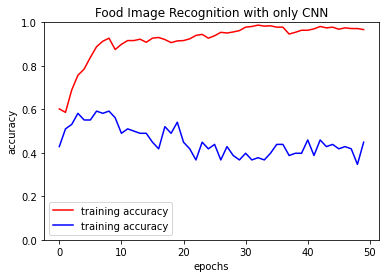

In [94]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(np.arange(50), training_accuracy, color="r", label="training accuracy")
plt.plot(np.arange(50), validation_accuracy, color="b", label="training accuracy")
plt.legend()
plt.title("Food Image Recognition with only CNN")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1)

#### From this figure and the previous supervised learning, we can find that the training accuracy is close to 100%, while validation accuracy and test accuracy is only about 40%. The reason is that the sample data is too small to learn well.
#### In the next step, I'll use various types of data augmentation for the classifier.